# Indian Classical Dance Classification (Local)

This notebook contains the complete, end-to-end project for classifying 8 types of Indian classical dance from images. We will perform the following steps:

1.  **Load & Explore:** Read the `train.csv` file with Pandas and explore the data (`df.head()`, class distribution).
2.  **Preprocess:** Create file paths, split the data into train/validation/test sets, and build a `tf.data` pipeline.
3.  **Model 1 (Baseline):** Build, train, and evaluate a Simple CNN from scratch.
4.  **Model 2 (Advanced):** Build, train, and evaluate a Transfer Learning model (MobileNetV2).
5.  **Compare:** Show a final table comparing the performance of both models.
6.  **Predict:** Use the best model to make a sample prediction on an unseen test image.

--- 
**IMPORTANT:** Before you run this, make sure you have:
1.  **Manually unzipped `archive.zip`** in this folder.
2.  **Installed the libraries** by running this in your terminal: `pip install tensorflow pandas scikit-learn matplotlib seaborn`
---

### Step 1: Load and Explore the Data (EDA)

Now we import our libraries and use **Pandas** to read the `train.csv` file. This file tells us which image file belongs to which dance class.

In [2]:
pip install tensorflow

  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached termcolor-3.2.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached wrapt-2.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cach

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import time

In [ ]:
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'
TRAIN_CSV = 'dataset/train.csv'
TEST_CSV = 'dataset/test.csv'

if not os.path.exists(TRAIN_DIR):
    print("ERROR: 'train' folder not found.")
    print("Please make sure you have manually unzipped 'archive.zip' in this directory.")
else:
    print("'train' folder found. Ready to proceed.")

df_train = pd.read_csv(TRAIN_CSV)

print("\nTraining Data Head:")
print(df_train.head())

'train' folder found. Ready to proceed.

Training Data Head:
     Image         target
0   96.jpg       manipuri
1  163.jpg  bharatanatyam
2  450.jpg         odissi
3  219.jpg      kathakali
4  455.jpg         odissi


Let's check the class distribution to see if the dataset is balanced.


Class Distribution:
target
mohiniyattam     50
odissi           49
kathakali        47
bharatanatyam    47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: count, dtype: int64


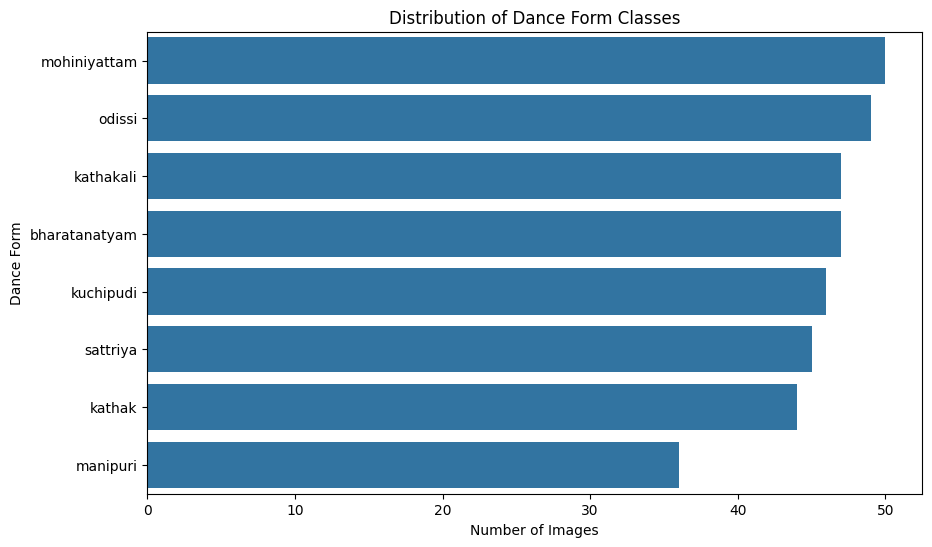

In [ ]:
print("\nClass Distribution:")
print(df_train['target'].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(y=df_train['target'], order=df_train['target'].value_counts().index)
plt.title('Distribution of Dance Form Classes')
plt.xlabel('Number of Images')
plt.ylabel('Dance Form')
plt.show()

The dataset is fairly balanced, which is good.

### Step 2: Preprocess and Split the Data

First, we'll create a full image path for each image. Then, we'll create a mapping from the class name (e.g., "bharatanatyam") to a number (e.g., 0), as models require numerical labels. 

**Crucially**, the `test.csv` file from Kaggle has no labels. To evaluate our model properly, we must split our `train.csv` data into three separate sets: **train**, **validation**, and **test**.

In [ ]:
df_train['image_path'] = df_train['Image'].apply(lambda x: os.path.join(TRAIN_DIR, x))

class_names = sorted(df_train['target'].unique())
NUM_CLASSES = len(class_names)
label_to_index = {label: index for index, label in enumerate(class_names)}
index_to_label = {index: label for index, label in enumerate(class_names)}

df_train['label_index'] = df_train['target'].map(label_to_index)

print(f"Total classes: {NUM_CLASSES} -> {class_names}")
print("\nDataFrame with new columns:")
print(df_train.head())

Total classes: 8 -> ['bharatanatyam', 'kathak', 'kathakali', 'kuchipudi', 'manipuri', 'mohiniyattam', 'odissi', 'sattriya']

DataFrame with new columns:
     Image         target             image_path  label_index
0   96.jpg       manipuri   dataset/train\96.jpg            4
1  163.jpg  bharatanatyam  dataset/train\163.jpg            0
2  450.jpg         odissi  dataset/train\450.jpg            6
3  219.jpg      kathakali  dataset/train\219.jpg            2
4  455.jpg         odissi  dataset/train\455.jpg            6


In [ ]:
X = df_train['image_path']
y = df_train['label_index']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Total Training samples:   {len(X_train)}")
print(f"Total Validation samples: {len(X_val)}")
print(f"Total Test samples:       {len(X_test)}")

Total Training samples:   254
Total Validation samples: 55
Total Test samples:       55


### Step 3: Build the Data Pipeline (`tf.data`)

We use `tf.data.Dataset` to create an efficient pipeline that will load, decode, and resize images on the fly.

In [ ]:
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 32

def load_and_preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img, label

def create_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X.values, y.values))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache() 
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = create_dataset(X_train, y_train, shuffle=True)
ds_validation = create_dataset(X_val, y_val)
ds_test = create_dataset(X_test, y_test)

print("TensorFlow Datasets created successfully.")

TensorFlow Datasets created successfully.


### Step 4: Build Models

As required, we will build two models for comparison.

First, we define a data augmentation layer to prevent overfitting on our small dataset.

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
], name="data_augmentation")

normalize = tf.keras.layers.Rescaling(1./255, name="rescaling")

#### Model 1: Simple CNN (Baseline)

This is a standard, 3-layer Convolutional Neural Network built from scratch.

In [ ]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    normalize,           
    data_augmentation,   
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax') # Output layer
], name="Simple_CNN")

model_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_1.summary()

d:\ML Project\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "Simple_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,402,824 (20.61 MB)

 Trainable params: 5,402,824 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Model 2: Transfer Learning (MobileNetV2)

This model uses a pre-trained backbone (MobileNetV2) and only trains a new classification "head". This is expected to be much more accurate.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False, # Don't include the final ImageNet classifier layer
    weights='imagenet'
)

base_model.trainable = False

inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs) 
x = preprocess_input(x)       
x = base_model(x, training=False) 
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x) 
model_2 = tf.keras.Model(inputs, outputs, name="MobileNetV2_Transfer")

model_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "MobileNetV2_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Step 5: Train the Models

Now we train both models. We'll use a small number of epochs, but you can increase this for better accuracy.

In [15]:
EPOCHS = 50 

print(f"\n--- Training Model 1: Simple CNN for {EPOCHS} epochs ---")
start_time_1 = time.time()
history_1 = model_1.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_validation
)
end_time_1 = time.time()
train_time_1 = end_time_1 - start_time_1
print(f"Model 1 training finished in {train_time_1:.2f} seconds.")
model_1.save("simple_cnn_model.keras")


--- Training Model 1: Simple CNN for 50 epochs ---
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 537ms/step - accuracy: 0.1181 - loss: 2.2541 - val_accuracy: 0.1455 - val_loss: 2.0762
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 445ms/step - accuracy: 0.1142 - loss: 2.0833 - val_accuracy: 0.1091 - val_loss: 2.0669
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - accuracy: 0.1732 - loss: 2.0569 - val_accuracy: 0.1636 - val_loss: 2.0441
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - accuracy: 0.1811 - loss: 2.0446 - val_accuracy: 0.1636 - val_loss: 2.0346
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 445ms/step - accuracy: 0.1457 - loss: 2.0230 - val_accuracy: 0.1818 - val_loss: 2.0667
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 422ms/step - accuracy: 0.2244 - loss: 1.9634 - val_accuracy: 0.3273 - val_loss: 1.9625
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.2717 - loss: 1.9155 - val_accuracy: 0.3091 - val_loss: 1.8337
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - accuracy: 0.27

In [16]:
print(f"\n--- Training Model 2: MobileNetV2 for {EPOCHS} epochs ---")
start_time_2 = time.time()
history_2 = model_2.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_validation
)
end_time_2 = time.time()
train_time_2 = end_time_2 - start_time_2
print(f"Model 2 training finished in {train_time_2:.2f} seconds.")
model_2.save("mobilenet_transfer_model.keras")


--- Training Model 2: MobileNetV2 for 50 epochs ---
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 711ms/step - accuracy: 0.1575 - loss: 2.4525 - val_accuracy: 0.2000 - val_loss: 2.0186
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step - accuracy: 0.2835 - loss: 2.0377 - val_accuracy: 0.4182 - val_loss: 1.6320
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step - accuracy: 0.3740 - loss: 1.6836 - val_accuracy: 0.5455 - val_loss: 1.3809
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - accuracy: 0.4606 - loss: 1.4289 - val_accuracy: 0.6000 - val_loss: 1.2445
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 450ms/step - accuracy: 0.4961 - loss: 1.3210 - val_accuracy: 0.6000 - val_loss: 1.1331
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - accuracy: 0.6102 - loss: 1.1030 - val_accuracy: 0.6909 - val_loss: 1.0028
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step - accuracy: 0.6496 - loss: 1.0506 - val_accuracy: 0.7273 - val_loss: 0.9609
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 442ms/step - accuracy: 0.

#### Visualize Training History

Let's plot the accuracy and loss curves for both models.

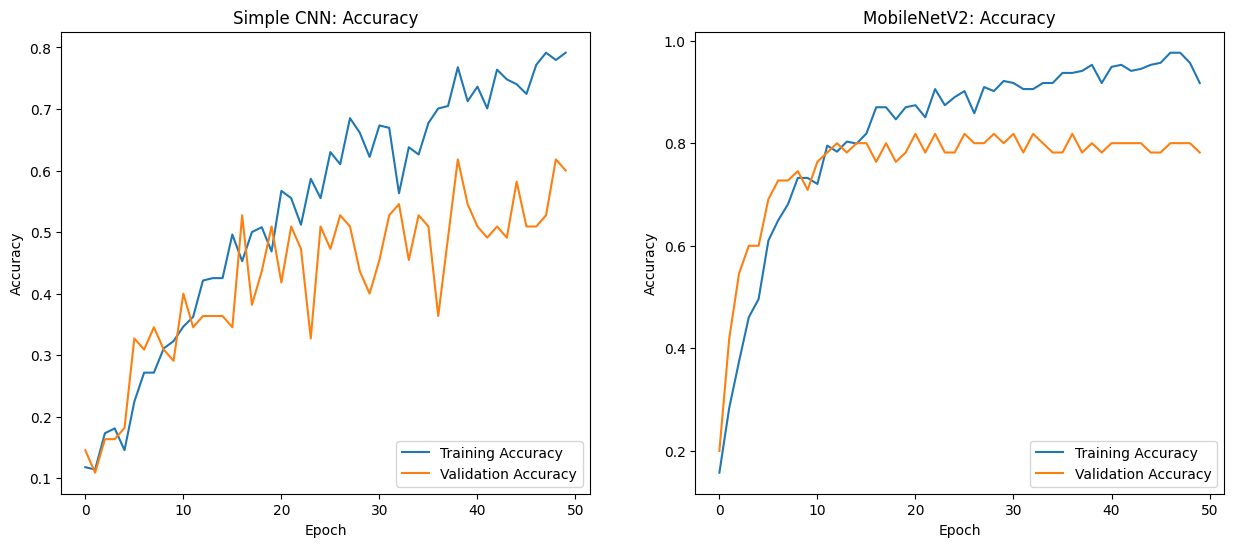

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Simple CNN: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('MobileNetV2: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

--- 
### Step 6: Comparative Evaluation

This is the most important part. We will evaluate both models on our held-out **test set** (the 55 images the models have never seen) and compare their Accuracy and F1-Scores.

In [ ]:
def evaluate_model(model, model_name, train_time):
    print(f"\n--- Evaluating: {model_name} ---")
    
    y_true = np.concatenate([y for x, y in ds_test])
    
    y_pred_probs = model.predict(ds_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    print(report)
    return accuracy, f1, train_time

acc_1, f1_1, time_1 = evaluate_model(model_1, "Model 1: Simple CNN", train_time_1)
acc_2, f1_2, time_2 = evaluate_model(model_2, "Model 2: MobileNetV2", train_time_2)


--- Evaluating: Model 1: Simple CNN ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Accuracy: 0.5818
Weighted F1-Score: 0.5768

Classification Report:
               precision    recall  f1-score   support

bharatanatyam       0.62      0.71      0.67         7
       kathak       0.57      0.67      0.62         6
    kathakali       0.71      0.71      0.71         7
    kuchipudi       0.67      0.29      0.40         7
     manipuri       1.00      0.40      0.57         5
 mohiniyattam       0.78      0.88      0.82         8
       odissi       0.33      0.38      0.35         8
     sattriya       0.40      0.57      0.47         7

     accuracy                           0.58        55
    macro avg       0.64      0.58      0.58        55
 weighted avg       0.62      0.58      0.58        55


--- Evaluating: Model 2: MobileNetV2 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Accuracy: 0.7091
Weighted F1-Score: 0.7030

Classification Report:
               precision    recall  f1-score 

--- 
### Step 7: Final Results Summary

Here is the final comparison. **These are the numbers you need for your README file.**

In [21]:
print("\n--- Final Results Summary ---")
print("----------------------------------------------------------------------")
print(f"| Model                 | Accuracy | Weighted F1-Score | Train Time (s) |")
print(f"|-----------------------|----------|-------------------|----------------|")
print(f"| 1. Simple CNN         | {acc_1:<8.4f} | {f1_1:<17.4f} | {time_1:<14.2f} |")
print(f"| 2. MobileNetV2 Transfer| {acc_2:<8.4f}| {f1_2:<17.4f} | {time_2:<14.2f} |")
print("----------------------------------------------------------------------")


--- Final Results Summary ---
----------------------------------------------------------------------
| Model                 | Accuracy | Weighted F1-Score | Train Time (s) |
|-----------------------|----------|-------------------|----------------|
| 1. Simple CNN         | 0.5818   | 0.5768            | 403.19         |
| 2. MobileNetV2 Transfer| 0.7091  | 0.7030            | 200.26         |
----------------------------------------------------------------------


#### Confusion Matrix (Best Model)

Let's visualize the performance of our best model (MobileNetV2) to see which classes it confused.

--- Confusion Matrix for Model 2 (MobileNetV2) ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step


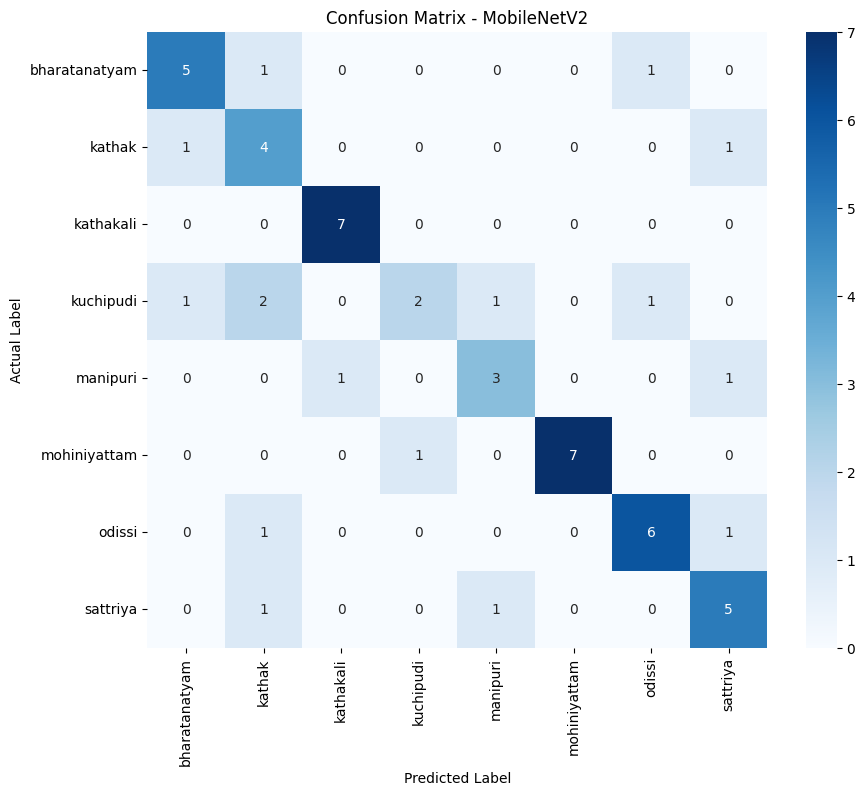

In [22]:
print("--- Confusion Matrix for Model 2 (MobileNetV2) ---")
y_true_test = np.concatenate([y for x, y in ds_test])
y_pred_probs_test = model_2.predict(ds_test)
y_pred_test = np.argmax(y_pred_probs_test, axis=1)

cm = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, yticklabels=class_names, 
            cmap='Blues')
plt.title('Confusion Matrix - MobileNetV2')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

--- 
### Step 8: Sample Prediction on Unseen Data

Finally, let's load our best model and use it to predict a single image from the original `test` folder (the ones from `test.csv` that we never used).

Loaded best model: MobileNetV2

--- Predicting on image: 145.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label: bharatanatyam
Confidence:     87.86%


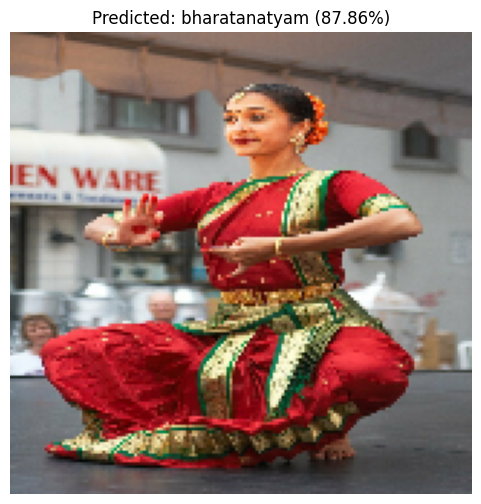

In [ ]:
best_model = tf.keras.models.load_model("mobilenet_transfer_model.keras")
print("Loaded best model: MobileNetV2")

df_test_kaggle = pd.read_csv(TEST_CSV)
df_test_kaggle['image_path'] = df_test_kaggle['Image'].apply(lambda x: os.path.join(TEST_DIR, x))

sample = df_test_kaggle.sample(1).iloc[0]
sample_image_path = sample['image_path']
sample_image_name = sample['Image']

print(f"\n--- Predicting on image: {sample_image_name} ---")

def load_image_for_prediction(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img_batch = tf.expand_dims(img, 0) 
    return img_batch, img 

img_batch, raw_img = load_image_for_prediction(sample_image_path)

prediction_probs = best_model.predict(img_batch)
predicted_index = np.argmax(prediction_probs[0])
predicted_class_name = index_to_label[predicted_index]
confidence = np.max(prediction_probs[0])

print(f"Predicted Label: {predicted_class_name}")
print(f"Confidence:     {confidence:.2%}")

plt.figure(figsize=(6, 6))
plt.imshow(raw_img / 255.0) 
plt.title(f"Predicted: {predicted_class_name} ({confidence:.2%})")
plt.axis('off')
plt.show()